In [13]:
import os
import torch
import torchvision
import tarfile
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
import numpy as np

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [3]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

KeyboardInterrupt: 

In [4]:
data_dir = './data/cifar10/'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
classes

['test', 'train']


['cat',
 'dog',
 'truck',
 'bird',
 'airplane',
 'ship',
 'frog',
 'horse',
 'deer',
 'automobile']

In [5]:
airplane_files = os.listdir(data_dir + 'train/airplane')
len(airplane_files)

5000

In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [7]:
dataset = ImageFolder(data_dir+'train', transform = ToTensor())
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root Location: ./data/cifar10/train
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [8]:
img, label = dataset[0]

In [9]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  automobile (1)


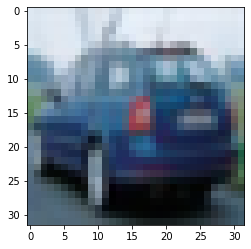

In [10]:
show_example(*dataset[7000])

In [11]:
torch.manual_seed(42)

In [15]:
val_size = 5000
batch_size=128
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [16]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128
import torch.nn as nn
import torch.nn.functional as F

In [17]:
simple_model = nn.Sequential(nn.Conv2d(3,8,kernel_size = 3, stride=1, padding=1), nn.MaxPool2d(2,2))

In [18]:
for images,labels in train_dl:
    print('images.shape: ', images.shape)
    out = simple_model(images)
    print('out.shape: ', out.shape)
    break

images.shape:  torch.Size([128, 3, 32, 32])
out.shape:  torch.Size([128, 8, 16, 16])


/Users/pradiptomondal/miniforge3/envs/tf/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-4zyfwhmc/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [19]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = self.accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
    def accuracy(self,outputs,labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
class cifar10(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,32,kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)


In [21]:
model = cifar10()
model

cifar10(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=102

In [22]:
for x in model:
    print(x)

TypeError: 'cifar10' object is not iterable

In [77]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0494,  0.0320, -0.0174,  0.0410, -0.0128,  0.0312, -0.0338, -0.0229,
         0.0299,  0.0287], grad_fn=<SelectBackward>)


In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        print(1)
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
device = get_default_device()
a = torch.tensor((2,3))
isinstance(model, (list, tuple))

False

In [33]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

cifar10(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=102

In [86]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [87]:
model = to_device(cifar10(), device)

In [88]:
evaluate(model, val_dl)

{'val_loss': 2.302766799926758, 'val_acc': 0.0995289534330368}

In [89]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [90]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7714, val_loss: 1.3878, val_acc: 0.4677
Epoch [1], train_loss: 1.2786, val_loss: 1.0988, val_acc: 0.6059
Epoch [2], train_loss: 1.0117, val_loss: 0.8919, val_acc: 0.6870
Epoch [3], train_loss: 0.8254, val_loss: 0.8176, val_acc: 0.7095
Epoch [4], train_loss: 0.6874, val_loss: 0.7919, val_acc: 0.7316
Epoch [5], train_loss: 0.5667, val_loss: 0.7335, val_acc: 0.7438
Epoch [6], train_loss: 0.4561, val_loss: 0.7415, val_acc: 0.7510
Epoch [7], train_loss: 0.3593, val_loss: 0.7760, val_acc: 0.7600
Epoch [8], train_loss: 0.2798, val_loss: 0.8296, val_acc: 0.7568
Epoch [9], train_loss: 0.2136, val_loss: 0.9356, val_acc: 0.7579
